# Predicting non-functional water pumps in Tanzania

# import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns

# for modelling
from sklearn.preprocessing import RobustScaler, LabelEncoder
from lightgbm import LGBMClassifier

# load data

In [4]:
train = pd.read_csv('data/raw/train.csv')
target = pd.read_csv('data/raw/target.csv')
test = pd.read_csv('data/raw/test.csv')

In [5]:
df_tt = pd.concat([test, train])

In [6]:
df_tt[['amount_tsh', 'num_private', 'population' ,'construction_year']] = \
    df_tt[['amount_tsh', 'num_private', 'population' ,'construction_year']].replace(0, np.NaN)

In [7]:
df_tt.drop(['wpt_name', 'recorded_by', 'longitude', 'latitude','scheme_name', 'num_private'], 
           1, inplace=True)

In [8]:
df_tt[['region_code', 'district_code']]= df_tt[['region_code', 'district_code']].astype('object')
df_tt[['date_recorded']]= df_tt[['date_recorded']].apply((pd.to_datetime))

categorical = df_tt.select_dtypes(include = ['object']).columns.tolist()
numerical = df_tt.select_dtypes(include = ['int', 'float']).columns.tolist()

In [37]:
# df = pd.merge(train, target, how = 'inner', on = 'id')

now 'id' no need to be keept

In [9]:
df_tt['missed_population'] = np.where(np.isnan(df_tt['population']), 1, 0)
df_tt['population'].fillna(0, inplace = True)

In [10]:
df_tt['approximated_amount_tsh'] = np.where(np.isnan(df_tt['amount_tsh']), 1, 0) 
replacements = df_tt.groupby('water_quality').amount_tsh.agg(pd.Series.mode).to_dict()

# all vlaues amount_tsh in this category is Nan
replacements.pop('fluoride abandoned')

df_tt.loc[df_tt['water_quality'] != 'soft', 'amount_tsh'] = \
    df_tt.loc[df_tt['water_quality'] != 'soft', 'amount_tsh'].fillna(replacements)

df_tt['amount_tsh'].fillna(0, inplace=True)

In [11]:
df_tt['wrong_gps_height'] = np.where(df_tt['gps_height'] < 0, 1, 0) 

In [12]:
df_tt['gps_height'] = abs(df_tt['gps_height'])

In [21]:
categories = 0
for col in categorical:
    categories += len(df_tt[col].unique())
    print(col, len(df_tt[col].unique()))
print('-------------------- \ntotal num:', categories)

funder 2141
installer 2411
basin 9
subvillage 21426
region 21
region_code 27
district_code 20
lga 125
ward 2098
public_meeting 3
scheme_management 13
permit 3
extraction_type 18
extraction_type_group 13
extraction_type_class 7
management 12
management_group 5
payment 7
payment_type 7
water_quality 8
quality_group 6
quantity 5
quantity_group 5
source 10
source_type 7
source_class 3
waterpoint_type 7
waterpoint_type_group 6
-------------------- 
total num: 28423


in test dataset we have new installers and funders

In [13]:
df_tt[categorical] = df_tt[categorical].astype('str')
df_tt[categorical] = df_tt[categorical].applymap(lambda x: x.lower())
nan_list = ['not known','unknown','none','-','##','not kno','unknown installer', '0', 'dwe']
df_tt = df_tt.replace(nan_list, np.nan)

for feature in df_tt[categorical]:
    # Determine which feature values to keep
    remove = df_tt[feature].value_counts()[df_tt[feature].value_counts() < 50].index.tolist()
    # Turn those into NANs (using a copy, to prevent warnings)
    feature_copy = df_tt[feature].copy()
    #feature_copy[~feature_copy.isin(to_keep)] = np.nan
    feature_copy[feature_copy.isin(remove)] = np.nan
    #print(feature_copy.isnull().sum())
    df_tt[feature] = feature_copy
# Fix all NANs
df_tt[categorical] = df_tt[categorical].fillna('other')

In [14]:
df_tt.drop(['region', 'district_code'], 1, inplace=True)
df_tt['region_code'] = df_tt['region_code'].astype(str)

In [15]:
df_tt.drop(['extraction_type_group', 'extraction_type_class'], 1, inplace=True)

In [16]:
df_tt['management_group'] = np.where(df_tt['management_group'] == 'user-group', 1, 0)

In [17]:
df_tt.drop('management', 1, inplace=True)

In [18]:
unpayable_types = ['never pay', 'other']
df_tt['payment'] = np.where(df_tt['payment'].isin(unpayable_types), 0, 1)

In [19]:
df_tt.drop('payment_type', 1, inplace=True)

In [20]:
df_tt.drop(['water_quality', 'quantity_group'], 1, inplace=True)
df_tt.quantity.replace({'dry': 'other'}, inplace=True)

In [21]:
df_tt.drop(['source_class', 'source_type'], 1, inplace=True)

In [22]:
df_tt.drop('waterpoint_type_group', 1, inplace=True)

In [23]:
df_tt['waterpoint_type'].replace({'cattle trough':'improved spring'}, inplace=True)

In [24]:
print('number of nans:', df_tt['construction_year'].isnull().sum())

number of nans: 25969


In [25]:
df_tt['construction_year'] = df_tt['construction_year'].fillna(0).astype(int)

coonst_y = list(df_tt['construction_year'].unique())
coonst_y.sort()

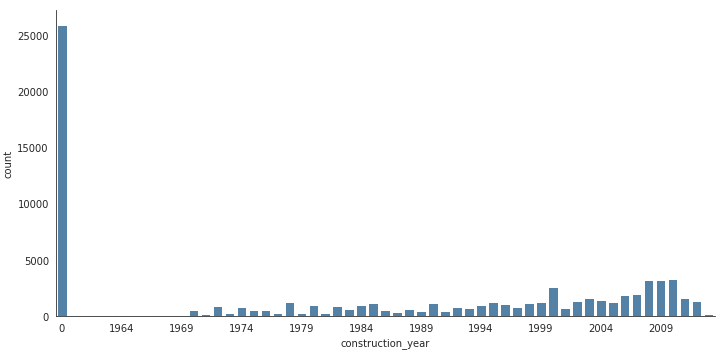

In [38]:
with sns.axes_style('white'):
    g = sns.factorplot("construction_year", data=df_tt, aspect=2,
                       kind="count", color='steelblue', order = coonst_y)
    g.set_xticklabels(step=5)

In [26]:
df_tt['approximated_construction_year'] = np.where(df_tt['construction_year'] == 0, 1, 0)

df_tt['construction_year'] = df_tt['construction_year'].replace(0, np.NaN)

In [27]:
replacements = df_tt.groupby(['funder', 'installer'])['construction_year'].transform('mean').round(0)
df_tt['construction_year'] = df_tt['construction_year'].fillna(replacements)

In [28]:
replacements = df_tt.groupby('installer')['construction_year'].transform('mean').round(0)
df_tt['construction_year'] = df_tt['construction_year'].fillna(replacements)

In [29]:
replacements = df_tt.groupby('funder')['construction_year'].transform('mean').round(0)
df_tt['construction_year'] = df_tt['construction_year'].fillna(replacements)

In [30]:
df_tt.construction_year.fillna(df_tt.construction_year.mode()[0], inplace=True)

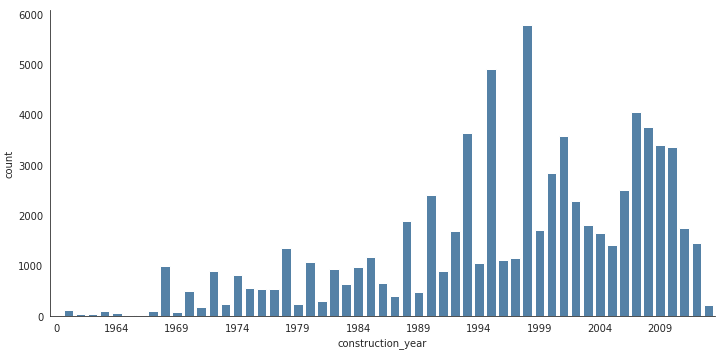

In [44]:
with sns.axes_style('white'):
    g = sns.factorplot("construction_year", data=df_tt, aspect=2,
                       kind="count", color='steelblue', order = coonst_y)
    g.set_xticklabels(step=5)

In [31]:
df_tt['lifetimes'] = df_tt['date_recorded'].dt.year - df_tt['construction_year']
df_tt['lifetimes'] = np.where(df_tt['lifetimes'] < 0, 0, df_tt['lifetimes'] )

df_tt.drop(['date_recorded', 'construction_year'], 1, inplace=True)

In [32]:
wp_in_lga = df_tt['lga'].value_counts().to_dict()
df_tt['wp_in_lga'] = df_tt['lga'].replace(wp_in_lga)

wp_in_ward = df_tt['ward'].value_counts().to_dict()
df_tt['wp_in_ward'] = df_tt['ward'].replace(wp_in_ward)

df_tt.drop(['subvillage', 'lga', 'ward'],1, inplace=True)

In [33]:
df_tt.to_csv('data/processed/prepeared_features_trian_test.csv', index=False)

# modelling

In [34]:
numerical = ['amount_tsh', 'gps_height', 'population', 'wp_in_lga', 'wp_in_ward', 'lifetimes']
binar = ['payment', 'missed_population', 'approximated_amount_tsh', 'wrong_gps_height', 
         'approximated_construction_year', 'management_group']
categorial = ['funder', 'installer', 'basin', 'region_code', 'public_meeting', 
              'scheme_management', 'permit', 'extraction_type', 'quality_group', 
              'quantity', 'source', 'waterpoint_type']
# without 'funder', 'installer' beckause they have too much values
categorial_short = ['basin', 'region_code', 'public_meeting', 'scheme_management',  
                    'permit', 'extraction_type', 'quality_group', 'quantity', 'source', 
                    'waterpoint_type']

In [51]:
df_train = pd.merge(df_tt, train['id'], on = 'id')

In [40]:
df_train_w_target = pd.merge(df_train, target, on = 'id')

In [42]:
df_train_w_target.drop('id', 1, inplace=True)

In [43]:
target = df_train_w_target['status_group'].replace(['functional', 'non functional', 'functional needs repair'], 
                                    [2, 0, 1])

In [46]:
train_dum = pd.get_dummies(df_train_w_target[categorial_short], dummy_na=False, prefix = categorial_short)
train_dum.shape

(59400, 94)

In [48]:
df_preproc = pd.concat([train_dum, df_trai_target[numerical + binar]], 1)
X_train, X_test, y_train, y_test = train_test_split(df_preproc, target, test_size=0.2, 
                                                    random_state=42, stratify = target)

In [44]:
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler, LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import cross_val_score, cross_validate, KFold, train_test_split, \
                RandomizedSearchCV

In [49]:
models = []

models.append(('LR', LogisticRegression(solver = 'lbfgs', multi_class='auto')))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))
models.append(('ET', ExtraTreesClassifier(n_jobs=-1)))
models.append(('XGBT', XGBClassifier(silent=True, n_jobs = -1)))
models.append(('LGBM', LGBMClassifier(silent=True)))
models.append(('CatBST', CatBoostClassifier(silent=True)))


accuracy_results = []
time_to_fit = []
names = []

for name, model in models:
    kfold = KFold(n_splits=7, random_state=42)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring='accuracy')
    accuracy_results.append(cv_results['test_score'])
    time_to_fit.append(cv_results['fit_time'])
    names.append(name)
    msg = '%s: %f (%f), takes: %f' % (name, cv_results['test_score'].mean(), 
                           cv_results['test_score'].std(), 
                           cv_results['fit_time'].mean())
    print(msg)

LR: 0.563510 (0.006429), takes: 1.960802
RF: 0.779398 (0.001655), takes: 0.614849
ET: 0.770665 (0.002588), takes: 0.710963
XGBT: 0.744697 (0.003023), takes: 5.570478
LGBM: 0.778178 (0.003002), takes: 1.263677
CatBST: 0.775926 (0.003908), takes: 92.256293


training on train dataset with taking into account test dataset shows a little bit better results

# preprocess features for train and test dataset

In [70]:
df_preproc_numeric = df_tt.copy()

scaler = RobustScaler()
nums_scaled = scaler.fit_transform(df_preproc_numeric[numerical])
nums_scaled = pd.DataFrame(nums_scaled, columns=numerical)
df_preproc_numeric[numerical] = nums_scaled

In [71]:
df_cat_labeled = df_preproc_numeric.copy() 
le = LabelEncoder()
df_cat_labeled[categorial] = df_cat_labeled[categorial].apply(lambda col: 
                                                              le.fit_transform(col.astype(str).fillna('nan')), 
                                                              axis = 0)

In [76]:
df_cat_labeled_full = pd.concat([df_cat_labeled[categorial], 
                                 df_cat_labeled[numerical], 
                                 df_cat_labeled[binar],
                                 df_cat_labeled['id']], 
                                 axis = 1)

In [77]:
X_train = pd.merge(df_cat_labeled_full, train['id'], on = 'id')

In [79]:
X_train.drop('id', 1, inplace = True)

retrain model on full train dataset

In [81]:
param_dist = {"max_depth": [10, 25, 50, 75],
              "learning_rate" : [0.01, 0.05, 0.1],
              "num_leaves": [50, 100, 300, 900, 1200],
              "n_estimators": [50, 100, 200],
              'feature_fraction' : [0.5, 0.8, 1],
              'bagging_fraction' : [0.8, 0.9, 1]
             }
lgbm_c = LGBMClassifier(silent=True, categorical_feature = list(range(len(categorial) - 1)))
lg_gs = RandomizedSearchCV(lgbm_c, 
                           n_jobs=-1, 
                           n_iter=100,
                           param_distributions=param_dist, 
                           cv = 7, 
                           scoring="accuracy", 
                           verbose=5)

lg_gs.fit(X_train, target)
lg_gs.best_estimator_

Fitting 7 folds for each of 100 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed: 31.2min finished


LGBMClassifier(bagging_fraction=0.9, boosting_type='gbdt',
               categorical_feature=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.1, max_depth=25,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=100, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [82]:
lg_gs.best_score_

0.783956228956229

make predictions

In [88]:
X_test = pd.merge(df_cat_labeled_full, test['id'], on = 'id')
predictions = lg_gs.predict(X_test.drop('id', 1))

submit_df = pd.DataFrame(X_test['id'])
submit_df['status_group'] = predictions

In [90]:
submit_df['status_group'] = submit_df['status_group'].replace([2, 0, 1],
                                     ['functional', 'non functional', 'functional needs repair'])
submit_df.to_csv('data/submissions/submit_1.csv', index = False)